<a href="https://colab.research.google.com/github/iguigu8191/first-git/blob/main/todai_medicalAI3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! wget https://www.dropbox.com/s/x0nhtd5v4ino22q/nih_xp_resized.tar.gz

--2021-04-27 13:27:37--  https://www.dropbox.com/s/x0nhtd5v4ino22q/nih_xp_resized.tar.gz
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:601a:18::a27d:712
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/x0nhtd5v4ino22q/nih_xp_resized.tar.gz [following]
--2021-04-27 13:27:37--  https://www.dropbox.com/s/raw/x0nhtd5v4ino22q/nih_xp_resized.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc04ed6e68310ea057429c56a611.dl.dropboxusercontent.com/cd/0/inline/BNag7hEhT_UcRMbMQCICPoP_Y9YauWMuf8xSCcloEXJtwoR82h3IU9rhyd5YIJ8hRDczJZzhMNAuMMDEEAaPsxjvTrNJeM5NXrBJov82hsYZdhstMCImTOJJ26ICtH49mvU9IOxufhZbC5_NqT6OFVRD/file# [following]
--2021-04-27 13:27:37--  https://uc04ed6e68310ea057429c56a611.dl.dropboxusercontent.com/cd/0/inline/BNag7hEhT_UcRMbMQCICPoP_Y9YauWMuf8xSCcloEXJtwoR82h3IU9rhyd5YIJ8

In [2]:
! tar -zxf ./nih_xp_resized.tar.gz

In [3]:
import pandas as pd
import numpy as np

df_train_val = pd.read_csv("/content/nih_xp_resized/img_labels_train_val.csv")
df_test = pd.read_csv("/content/nih_xp_resized/img_labels_test.csv")

In [4]:
# 学習用・テスト用の画像データセット作成

import matplotlib.pyplot as plt
import cv2


import os 
import numpy as np
import torch

def read_imgs(file_names, img_dir='/content/nih_xp_resized/images_96', width=96, height=96):
    result = []
    for file_name in file_names:
        img = cv2.imread(os.path.join(img_dir, file_name), 0)
        img_array = np.array(img).reshape(1, 1, width, height)
        result.append(img_array)
    return result

img_train_val = read_imgs(df_train_val['Image Index'])
img_train_val = torch.tensor(np.concatenate(img_train_val, axis=0))

img_test = read_imgs(df_test['Image Index'])
img_test = torch.tensor(np.concatenate(img_test, axis=0))

print("Size of train_val: ", img_train_val.shape)
print("Size of test: ", img_test.shape)

Size of train_val:  torch.Size([25000, 1, 96, 96])
Size of test:  torch.Size([5805, 1, 96, 96])


In [5]:
# 学習用・テスト用の正解データセット作成
# 2値分類で行う。
# Finding Labelsが"No Finding"であれば 0 、それ以外は1となるように正解データを作成する

label_train_val = []
for label in df_train_val['Finding Labels']:
    if label == "No Finding":
        label_train_val.append(0)
    else:
        label_train_val.append(1)

label_test = []
for label in df_test['Finding Labels']:
    if label == "No Finding":
        label_test.append(0)
    else:
        label_test.append(1)

label_train_val = torch.tensor(label_train_val)
label_test = torch.tensor(label_test)

print(label_train_val.size())
print(label_test.size())

torch.Size([25000])
torch.Size([5805])


In [6]:
import numpy as np

import torch
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision.models import resnet50
import torch.nn as nn

from sklearn.datasets import fetch_openml
from sklearn.model_selection import KFold

In [7]:
class MyDataset(torch.utils.data.Dataset):

    def __init__(self, data, label, transform=None):
        self.transform = transform
        self.data = data
        self.data_num = len(data)
        self.label = label

    def __len__(self):
        return self.data_num

    def __getitem__(self, idx):
        data = self.data[idx]
        label = torch.from_numpy(np.array(self.label[idx]))

        if self.transform:
            data = self.transform(data)

        sample = (data, label)
        return sample

In [8]:
def train(net, train_loader):
    net.train()
    running_loss = 0
    correct = 0
    total = 0

    for batch_idx, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        images= images.float()

        optimizer.zero_grad()
        outputs = net(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predict = torch.max(outputs.data, 1)
        correct += (predict == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    return net, train_loss, train_acc

def valid(net, valid_loader):
    net.eval()
    running_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(valid_loader):
            images = images.to(device)
            labels = labels.to(device)
            images = images.float()

            outputs = net(images)

            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predict = torch.max(outputs.data, 1)
            correct += (predict == labels).sum().item()
            total += labels.size(0)

    val_loss = running_loss / len(valid_loader)
    val_acc = correct / total

    return net, val_loss, val_acc

def test(net, valid_loader):
    net.eval()
    running_loss = 0
    correct = 0
    total = 0
    
    r = 0
    o = 0

    tp = 0
    tn = 0
    fp = 0
    fn =0

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(valid_loader):
            images = images.to(device)
            labels = labels.to(device)
            images = images.float()

            outputs = net(images)

            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predict = torch.max(outputs.data, 1)
            correct += (predict == labels).sum().item()
            total += labels.size(0)

                        #異常なし：０、異常あり：１
            tn += (predict < labels).sum().item()
            fp += (predict > labels).sum().item()

            r += (predict == torch.tensor([0], device='cuda:0')).sum().item()
            tp = r - fp
            o += (predict == torch.tensor([0], device='cuda:0')).sum().item()
            fn = o - tn

    test_loss = running_loss / len(valid_loader)
    test_acc = correct / total

    test_recall = tp / (tp + fp)
    test_precision = tp / (tp + fn)
    test_f_measure = 2 * test_recall * test_precision / ( test_recall + test_precision)

    return net, test_loss, test_acc, test_recall, test_precision, test_f_measure

In [12]:
num_epochs = 2
batch_size = 64
learning_rate = 0.01

In [13]:
n_splits = 5

dataset = MyDataset(data=img_train_val, label=label_train_val, transform=None)

device = 'cuda:0'
criterion = nn.CrossEntropyLoss()
fold = KFold(n_splits=n_splits, shuffle=True, random_state=0)

In [52]:
print(resnet50)

<function resnet50 at 0x7f4329469cb0>


In [14]:
cv = 0.0
a = 0
b = 0
c = 0
d = 0

for fold_idx, (train_idx, valid_idx) in enumerate(fold.split(dataset.data, dataset.label)):
    print('fold {}'.format(fold_idx))
    net = resnet50(num_classes=2)
    net.conv1 = nn.Conv2d(1, 64, kernel_size=5, stride=2, padding=3, bias=False)
    net = net.to(device)
    optimizer = torch.optim.Adam(params=net.parameters(), lr=0.001)

    train_loader = DataLoader(Subset(dataset, train_idx), shuffle=True, batch_size=batch_size)
    valid_loader = DataLoader(Subset(dataset, valid_idx), shuffle=False, batch_size=batch_size)

    for epoch_idx in range(num_epochs):

        net, train_loss, train_acc = train(net, train_loader)
        net, valid_loss, valid_acc = valid(net, valid_loader)

        print('train_loss {:.3f} valid_loss {:.3f} train_acc {:.3f} valid_acc {:.3f}'.format(train_loss, valid_loss, train_acc, valid_acc))

    cv += valid_acc / fold.n_splits

    test_set = MyDataset(img_test, label_test)

    test_loader = torch.utils.data.DataLoader(test_set,
                                             shuffle=True, num_workers=2)

    net, test_loss, test_acc, test_recall, test_precision, test_f_measure = test(net, test_loader)

    print('test_acc {:.3f} test_recall {:.3f} test_precision {:.3f} test_f_measure {:.3f}'.format(test_acc, test_recall, test_precision, test_f_measure))

    a += test_acc
    b += test_recall
    c += test_precision
    d += test_f_measure  

    torch.save(net.state_dict(), "net.pth")

average_acc = a / n_splits
average_recall = b / n_splits
average_precision = c / n_splits
average_f_measure  = d / n_splits

print('average_acc {:.3f} average_recall {:.3f} average_precision {:.3f} average_f_measure {:.3f}'.format(average_acc, average_recall, average_precision, average_f_measure))

fold 0
train_loss 0.649 valid_loss 0.609 train_acc 0.697 valid_acc 0.710
train_loss 0.591 valid_loss 0.595 train_acc 0.709 valid_acc 0.710
test_acc 0.663 test_recall 0.967 test_precision 0.590 test_f_measure 0.733
fold 1
train_loss 0.643 valid_loss 0.654 train_acc 0.699 valid_acc 0.700
train_loss 0.594 valid_loss 0.593 train_acc 0.708 valid_acc 0.701
test_acc 0.658 test_recall 0.995 test_precision 0.602 test_f_measure 0.750
fold 2
train_loss 0.641 valid_loss 0.598 train_acc 0.693 valid_acc 0.704
train_loss 0.590 valid_loss 0.582 train_acc 0.706 valid_acc 0.711
test_acc 0.655 test_recall 0.999 test_precision 0.604 test_f_measure 0.753
fold 3
train_loss 0.639 valid_loss 0.595 train_acc 0.693 valid_acc 0.694
train_loss 0.598 valid_loss 0.595 train_acc 0.703 valid_acc 0.701
test_acc 0.663 test_recall 0.993 test_precision 0.600 test_f_measure 0.748
fold 4
train_loss 0.647 valid_loss 0.647 train_acc 0.692 valid_acc 0.709
train_loss 0.589 valid_loss 0.629 train_acc 0.706 valid_acc 0.698
test_

In [21]:
import torch.optim as optim
from torchvision import datasets, models, transforms

import os 
import copy
from PIL import Image

In [18]:
class GradCAM:
    def __init__(self, model, feature_layer):
        self.model = model
        self.feature_layer = feature_layer
        self.model.eval()
        self.feature_grad = None
        self.feature_map = None
        self.hooks = []

        def save_feature_grad(module, in_grad, out_grad):
            self.feature_grad = out_grad[0]
        
        self.hooks.append(self.feature_layer.register_backward_hook(save_feature_grad))

        def save_feature_map(module, inp, outp):

            self.feature_map = outp[0]

        self.hooks.append(self.feature_layer.register_forward_hook(save_feature_map))

    def forward(self, x):
        return self.model(x)

    def backward_on_target(self, output, target):
        
        self.model.zero_grad()
        one_hot_output = torch.zeros([1, output.size()[-1]])
        one_hot_output[0][target] = 1

        output.backward(gradient=one_hot_output, retain_graph=True)

    def clea_hook(self):
        for hook in self.hooks:
            hook.remove()


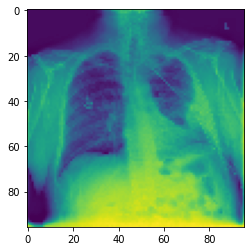

In [49]:
drive_dir = "drive/My Drive/Colab Notebooks/grad-cam/image_only5/"

path = drive_dir + "00023313_007.png"
VISUALIZE_SIZE = (224, 224)
image = Image.open(path)
image.thumbnail(VISUALIZE_SIZE)

plt.imshow(image)

In [33]:
image_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [51]:
image_oring_size = image.size

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),                                
])

test_image_tensor = transform(image)
test_image_tensor = test_image_tensor.unsqueeze(0)
device = torch.device("cpu")
model = models.resnet50(pretrained=False)
n_classes = 2
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, n_classes)
model.to(device)
model.eval()

from collections import OrderedDict
import torch
checkpoint=torch.load("net.pth")

state_dict = checkpoint
new_state_dict = OrderedDict()

model.load_state_dict(state_dict)

RuntimeError: ignored